In [258]:
import cv2
import os
import numpy as np
import pandas as pd 
from tqdm import tqdm
import random
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential, save_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [259]:
labels_ = {"cardboard": 0, "paper": 1, "glass": 2, "metal": 3, "trash": 4,  "plastic": 5 }
size = (224, 224)

In [260]:
def load_data(path: str, size: tuple = (150, 150)) -> tuple:
    images = []
    labels = []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for img_name in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size)
                    images.append(img)
                    labels.append(labels_[class_name])
                else:
                    print(f"Image {img_name} in class {class_name} is None, skipping.")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [261]:
imgs_data, labels_data = load_data("./Garbage classification/Garbage classification", size)

Loading trash: 100%|██████████| 137/137 [00:00<00:00, 802.83it/s]


In [262]:
print(len(imgs_data), len(labels_data))

2527 2527


In [263]:
#Data augmentation 
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment the dataset
augmented_images = []
augmented_labels = []
augmentation_count = int(len(imgs_data) * (1/3))

for img, label in zip(imgs_data, labels_data):
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype('uint8'))
        augmented_labels.append(label)
        i += 1
        if i >= (augmentation_count / len(imgs_data)):
            break

# Combine the original and augmented data
final_imgs_data = np.concatenate((imgs_data, augmented_images), axis=0)
final_labels_data = np.concatenate((labels_data, augmented_labels), axis=0)

In [264]:
# class distribution 
label_names = [list(labels_.keys())[list(labels_.values()).index(label)] for label in final_labels_data]

label_counts = pd.Series(label_names).value_counts()

fig = px.pie(
    values=label_counts.values,
    names=label_counts.index, 
    title="Class Distribution",
    hole=0.4  
)
fig.show()

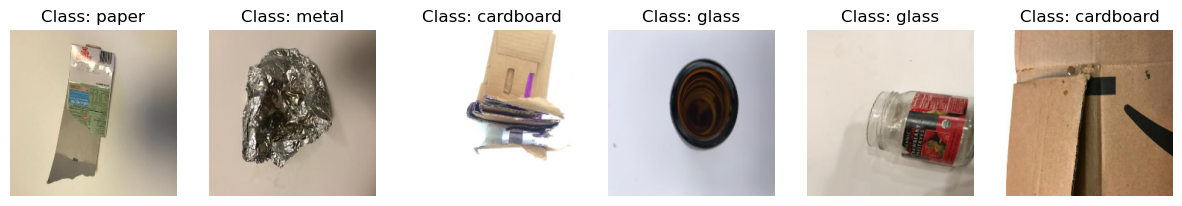

In [265]:
# final images check(randomly)
num_images = 6
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
indices = random.sample(range(len(final_imgs_data)), num_images)

for ax, idx in zip(axes, indices):
    ax.imshow(cv2.cvtColor(final_imgs_data[idx], cv2.COLOR_BGR2RGB))
    class_name = list(labels_.keys())[list(labels_.values()).index(final_labels_data[idx])]
    ax.set_title(f"Class: {class_name}")
    ax.axis("off")

plt.show()

In [266]:
# train-test split 
X_train, X_test, y_train, y_test = train_test_split(final_imgs_data, final_labels_data, test_size=0.2, random_state=42)

In [267]:
# normalization 
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

In [268]:
model_accuracies = []
num_classes = len(np.unique(y_train))

In [269]:
# CNN without Data Augmentation 
def basic_cnn(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=SparseCategoricalCrossentropy(),
        metrics=[SparseCategoricalAccuracy()]
    )
    return model

In [270]:
cnn_model = basic_cnn()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 357ms/step - loss: 2.4433 - sparse_categorical_accuracy: 0.2489 - val_loss: 1.3867 - val_sparse_categorical_accuracy: 0.4363
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 331ms/step - loss: 1.3837 - sparse_categorical_accuracy: 0.4450 - val_loss: 1.5534 - val_sparse_categorical_accuracy: 0.3548
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 322ms/step - loss: 1.2903 - sparse_categorical_accuracy: 0.4747 - val_loss: 1.1686 - val_sparse_categorical_accuracy: 0.5538
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 323ms/step - loss: 1.1288 - sparse_categorical_accuracy: 0.5785 - val_loss: 1.1003 - val_sparse_categorical_accuracy: 0.5871
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 346ms/step - loss: 0.9038 - sparse_categorical_accuracy: 0.6557 - val_loss: 1.0522 - val_sparse_categorical_accuracy: 0.6143
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 314ms/step - loss: 0.7033 - sparse_categorical_accuracy: 0.7509 - val_loss: 1.1118 - val_sparse_categorical_acc

In [298]:
cnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,197,524 (508.11 MB)

 Trainable params: 44,399,174 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,798,350 (338.74 MB)

In [271]:
# Evaluate "CNN without DataAugmentation model" 
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN without Data Augmentation - Test Accuracy: {accuracy*100:.2f}%")
model_accuracies.append(accuracy * 100)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 1.1403 - sparse_categorical_accuracy: 0.5864
CNN without Data Augmentation - Test Accuracy: 59.94%


In [272]:
# CNN with Data Augmentation
cnn_aug_model = basic_cnn()
datagen.fit(X_train)
history_cnn_aug = cnn_aug_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=(X_train[int(0.8*len(X_train)):], y_train[int(0.8*len(X_train)):]),
    callbacks=[early_stopping]
)

c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 381ms/step - loss: 2.8236 - sparse_categorical_accuracy: 0.2707 - val_loss: 1.3027 - val_sparse_categorical_accuracy: 0.4808
Epoch 2/20
  1/126 ━━━━━━━━━━━━━━━━━━━━ 39s 314ms/step - loss: 1.3169 - sparse_categorical_accuracy: 0.4688

c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.3169 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.3065 - val_sparse_categorical_accuracy: 0.4635
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 48s 384ms/step - loss: 1.4122 - sparse_categorical_accuracy: 0.4232 - val_loss: 1.2847 - val_sparse_categorical_accuracy: 0.4994
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.3765 - sparse_categorical_accuracy: 0.3750 - val_loss: 1.2211 - val_sparse_categorical_accuracy: 0.5216
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 48s 380ms/step - loss: 1.3567 - sparse_categorical_accuracy: 0.4433 - val_loss: 1.2071 - val_sparse_categorical_accuracy: 0.5043
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1468 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.2195 - val_sparse_categorical_accuracy: 0.5043
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 48s 376ms/step - loss: 1.2948 - sparse_categorical_accuracy: 0.4889 - val_loss: 1.0362 - val_sparse_categorical_accuracy: 0.5822
Epo

In [299]:
cnn_aug_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,197,524 (508.11 MB)

 Trainable params: 44,399,174 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,798,350 (338.74 MB)

In [273]:
# Evaluate "CNN with DataAugmentation model" 
loss, accuracy = cnn_aug_model.evaluate(X_test, y_test)
print(f"CNN with Data Augmentation - Test Accuracy: {accuracy*100:.2f}%")
model_accuracies.append(accuracy * 100)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.8726 - sparse_categorical_accuracy: 0.6946
CNN with Data Augmentation - Test Accuracy: 70.23%


In [274]:
# using pretrained mobilenetv2 model 
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

###### mobilenetv2를 base model(pretrained) 로 선택한 이유: 일단 가벼운 모델로서 리소스가 적거나 데이터가 충분치 않은 상황에서 쓰기 좋은 모델이기에 선정 

###### 처음에는 사전학습된 imagenet데이터셋에서 학습된 가중치를 쓰고 fclayer 제거해서 직접 custom한 레이어 추가 해줌

In [275]:
# first freeze the base model 
base_model.trainable = False

In [276]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(len(np.unique(labels_data)), activation='softmax') 
])

In [277]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [278]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [279]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - loss: 1.3591 - sparse_categorical_accuracy: 0.4733 - val_loss: 0.7396 - val_sparse_categorical_accuracy: 0.7454
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.7816 - val_loss: 0.6045 - val_sparse_categorical_accuracy: 0.7923
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - loss: 0.4582 - sparse_categorical_accuracy: 0.8433 - val_loss: 0.5338 - val_sparse_categorical_accuracy: 0.8121
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - loss: 0.3662 - sparse_categorical_accuracy: 0.8915 - val_loss: 0.4994 - val_sparse_categorical_accuracy: 0.8208
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - loss: 0.3188 - sparse_categorical_accuracy: 0.8954 - val_loss: 0.4640 - val_sparse_categorical_accuracy: 0.8381
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - loss: 0.2847 - sparse_categorical_accuracy: 0.9199 - val_loss: 0.4679 - val_sparse_categorical_acc

In [280]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pre-trained MobileNetV2 - Test Accuracy: {accuracy*100:.2f}%")
model_accuracies.append(accuracy * 100)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.4681 - sparse_categorical_accuracy: 0.8262
Pre-trained MobileNetV2 - Test Accuracy: 82.20%


In [281]:
# compile the model again for the fine tuning 
initial_learning_rate = 0.00001
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(), 
              metrics=[SparseCategoricalAccuracy()])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [282]:
# fine tuning : Unfreezing some layeers in the base of the pretrained model 
base_model.trainable = True
set_trainable = False

for layer in base_model.layers:
    if 'conv5_block16' in layer.name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [283]:
def lr_step_decay(epoch):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * (drop_rate ** np.floor((1 + epoch) / epochs_drop))

In [284]:
# training model agagin after finetuning 
history_fine_tune = model.fit(
    X_train, y_train,
    epochs=50,  
    batch_size=32,
    validation_split=0.2,
    callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)]
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - loss: 0.2587 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.4609 - val_sparse_categorical_accuracy: 0.8418 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - loss: 0.2416 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.4582 - val_sparse_categorical_accuracy: 0.8368 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-05.
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - loss: 0.2433 - sparse_categorical_accuracy: 0.9442 - val_loss: 0.4522 - val_sparse_categorical_accuracy: 0.8405 - learning_rate: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1e-05.
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - loss: 0.2372 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.4506 - val_sparse_categorical_a

In [285]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Fine-tuned MobileNetV2 - Test Accuracy: {accuracy*100:.2f}%")
model_accuracies.append(accuracy * 100)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 0.4300 - sparse_categorical_accuracy: 0.8390
Fine-tuned MobileNetV2 - Test Accuracy: 83.88%


In [286]:
# model accuracy comparing visualization  
# classificatoin Report 
# confusion matrix로 확인
# predicted images visualziation 

In [287]:
# comparing models 
accuracy_data = {
    'Model': ['CNN without Data Augmentation', 'CNN with Data Augmentation', 'MobilenetV2 model', 'MobilenetV2 fine tuned model'],
    'Accuracy (%)': model_accuracies
}
df = pd.DataFrame(accuracy_data)
print("\nAccuracy Comparison:")
df 


Accuracy Comparison:


,Model,Accuracy (%)
0,CNN without Data Augmentation,59.940654
1,CNN with Data Augmentation,70.227498
2,MobilenetV2 model,82.195848
3,MobilenetV2 fine tuned model,83.877349


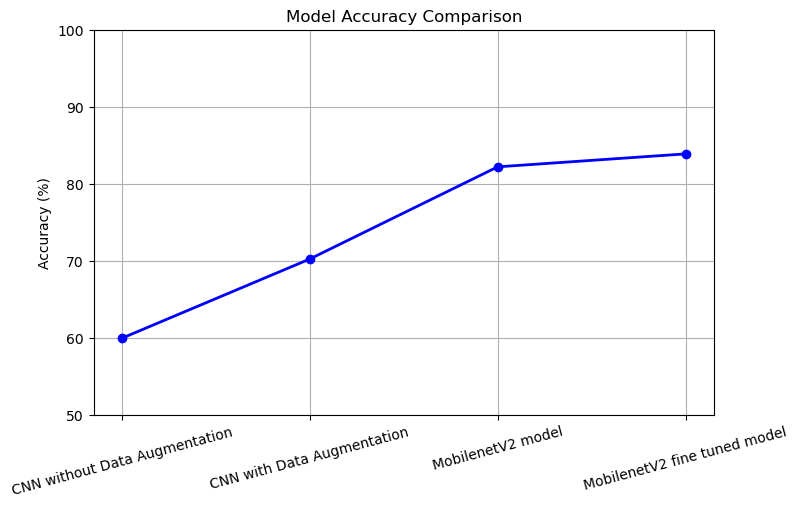

In [288]:
plt.figure(figsize=(8, 5))
plt.plot(df['Model'], df['Accuracy (%)'], marker='o', linestyle='-', color='b', linewidth=2)
# plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(50, 100)
plt.grid(True)
plt.xticks(rotation=15) 
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step


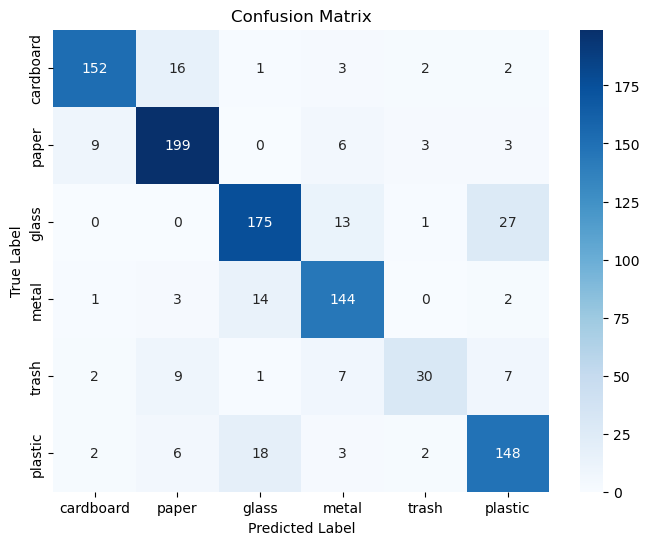

In [289]:
import seaborn as sns
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_.keys(), yticklabels=labels_.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [290]:
print("Classification Report:\n", classification_report(y_test, y_pred_labels, target_names=labels_.keys()))

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.92      0.86      0.89       176
       paper       0.85      0.90      0.88       220
       glass       0.84      0.81      0.82       216
       metal       0.82      0.88      0.85       164
       trash       0.79      0.54      0.64        56
     plastic       0.78      0.83      0.80       179

    accuracy                           0.84      1011
   macro avg       0.83      0.80      0.81      1011
weighted avg       0.84      0.84      0.84      1011



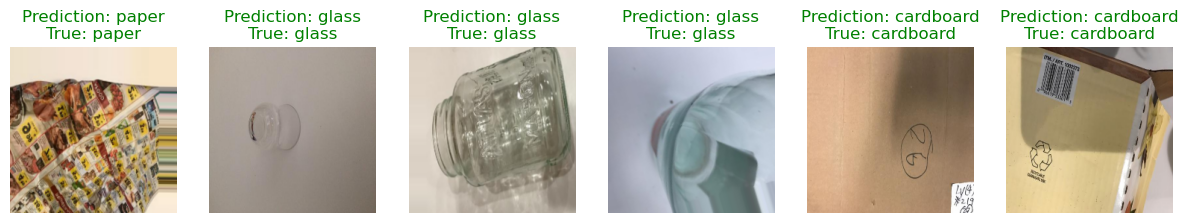

In [297]:
num_images = 6
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
indices = random.sample(range(len(X_test)), num_images)

for ax, idx in zip(axes, indices):
    ax.imshow(cv2.cvtColor((X_test[idx] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    predicted_class = list(labels_.keys())[y_pred_labels[idx]]
    true_class = list(labels_.keys())[y_test[idx]]
    ax.set_title(f"Prediction: {predicted_class}\nTrue: {true_class}", color="green" if predicted_class == true_class else "red")
    ax.axis("off")

plt.show()